# Experiment: Prequential Pipeline - Online Classification

In this exemplary experiment we use float to compare three online classifiers with respect to different performance measures. We use a prequential evaluation strategy.

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river.linear_model import Perceptron, LogisticRegression

# Import float modules
from float.data import DataLoader
from float.data.preprocessing import SklearnScaler
from float.pipeline import PrequentialPipeline
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.river import RiverClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.evaluation.measures import noise_variability
import float.visualization as fvis

### Setup *float* modules

#### Create a DataLoader object
We load the Electricity data set (https://www.openml.org/d/151) and specify an sklearn MinMaxScaler for the normalization.

In [3]:
data_loader = DataLoader(path='float/data/datasets/electricity.csv',  # This path might have to be adjusted!
                         target_col=-1,
                         scaler=SklearnScaler(MinMaxScaler())
                         )

#### Create Predictor objects
We setup a list of predictors. Specifically, we want to compare models from skmultiflow and river. We use the default parameters of the packages, however, in general you can provide any configuration you like.

In [4]:
predictors = [SkmultiflowClassifier(model=HoeffdingAdaptiveTreeClassifier(), classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), classes=data_loader.stream.target_values),
              RiverClassifier(model=LogisticRegression(), feature_names=data_loader.stream.feature_names)
              ]

#### Create a PredictorEvaluator object.
The evaluator will compute and store the performance measures when running the pipeline. Float automatically clones the provided evaluator for each specified predictor object.

We specify a fading factor and a sliding window, i.e. the evaluator will additionally store aggregated measures with an exponential decay and in a sliding window.

Note that you can hand any parameter of a measure function directly to the Evaluator, e.g. below we specify the zero_division parameter of the precision_score and the reference_measure and n_samples parameters of the noise_variability.

In [5]:
evaluator = PredictionEvaluator(measure_funcs=[accuracy_score, precision_score, noise_variability],
                                decay_rate=0.1,
                                window_size=25,
                                zero_division=0,
                                reference_measure=accuracy_score,
                                n_samples=15)

#### Create and run a PrequentialPipeline

We use a batch-incremental scheme, processing the data in batches of size 100. Moreover, we pretrain the classifiers on 200 observations and set a random state for reproducibility.

In [6]:
pipeline = PrequentialPipeline(data_loader=data_loader,
                               predictor=predictors,
                               prediction_evaluator=evaluator,
                               batch_size=100,
                               n_pretrain=200,
                               n_max=data_loader.stream.n_samples,  # We use all observations
                               random_state=0)
pipeline.run()

Pretrain the predictor with 200 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 234.21224570274353s
Data Set: float/data/datasets/electricity.csv
The PrequentialPipeline has processed 45312 instances, using batches of size 100.
-------------------------------------------------------------------------
*** Prediction ***
Model: SkmultiflowClassifier.HoeffdingAdaptiveTreeClassifier
| Performance Measure    |      Value |
|------------------------|------------|
| Avg. Test Comp. Time   |  0.0147068 |
| Avg. Train Comp. Time  |  0.0803129 |
| Avg. accuracy_score    |  0.751755  |
| Avg. precision_score   |  0.793886  |
| Avg. noise_variability | -0.251952  |
Model: SkmultiflowClassifier.HoeffdingTreeClassifier
| Performance Measure    |      Value |
|------------------------|------------|
| Avg. Test Comp. Time   |  0.010784  |
| Avg. Train Comp. Time  |  0.0182686 |
| Avg. accuracy_score

The summarized results suggest that the HoeffdingAdaptiveClassifier has slight advantages w.r.t. the accuracy and precision. We may get further insight into the performance of the classifiers by using the visualization module of float.

### Visualizing Results

Float provides standardized plot types that may be used to illustrate results stored in an evaluator object. 
However, note that you can essentially do whatever you like with the evaluator object, e.g. save it or create custom tables.

The evaluator object contains all results, e.g. performance measures and computation times, that were calculated during the pipeline run. Since we trained 3 predictors, the pipeline.prediction_evaluators object contains 3 evaluators.

We begin by illustrating the raw accuracy measures of each classifier using a regular line plot.

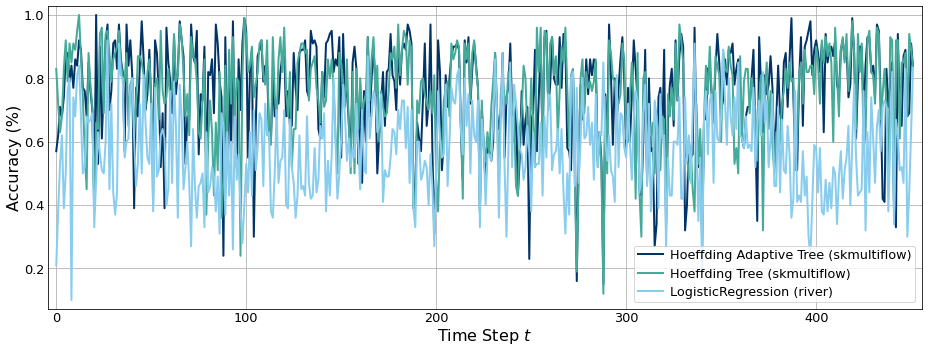

In [7]:
ax = fvis.plot(measures=[evaluator.result['accuracy_score']['measures'] for evaluator in pipeline.prediction_evaluators],
               legend_labels=['Hoeffding Adaptive Tree (skmultiflow)', 
                              'Hoeffding Tree (skmultiflow)', 
                              'LogisticRegression (river)'],
               y_label='Accuracy (%)')

#plt.savefig('float/experiments/accuracy.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

The HoeffdingTreeClassifier and the HoeffdingAdaptiveTreeClassifier outperform the LogisticRegression model during most of the time. Yet, it is hard to identify overall trends from the raw measures. However, remember that we also computed aggregations of the raw measures, which we may compare instead.

Specifically, we can compare the **aggregated mean and variance** (where each sample has equal weight) and the mean and variance for a **sliding window** and **fading factor**.

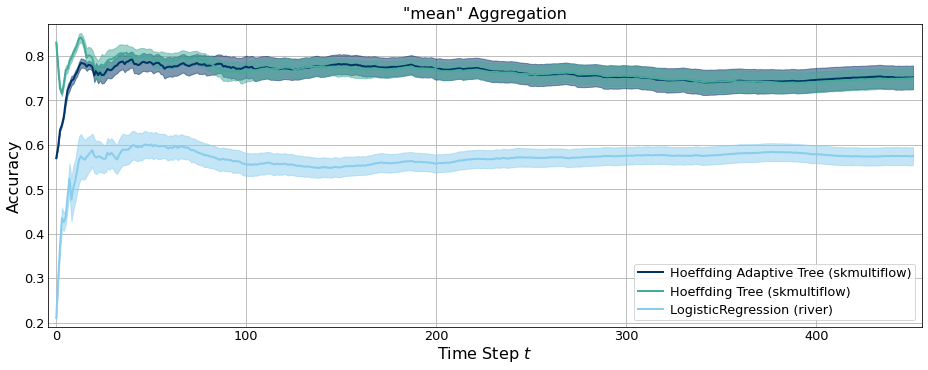

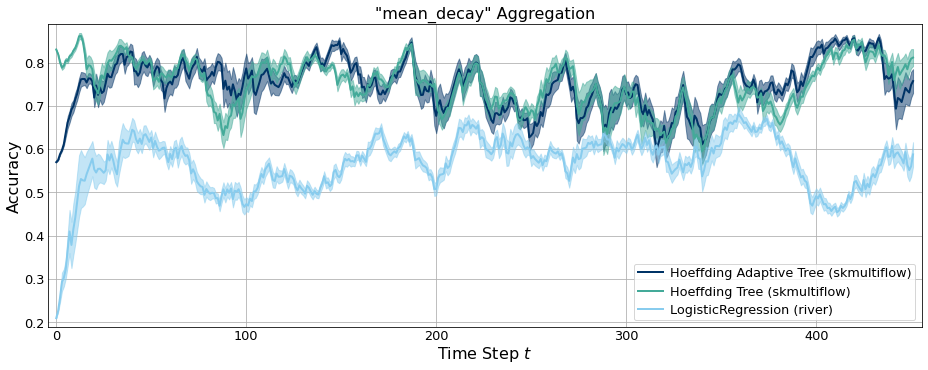

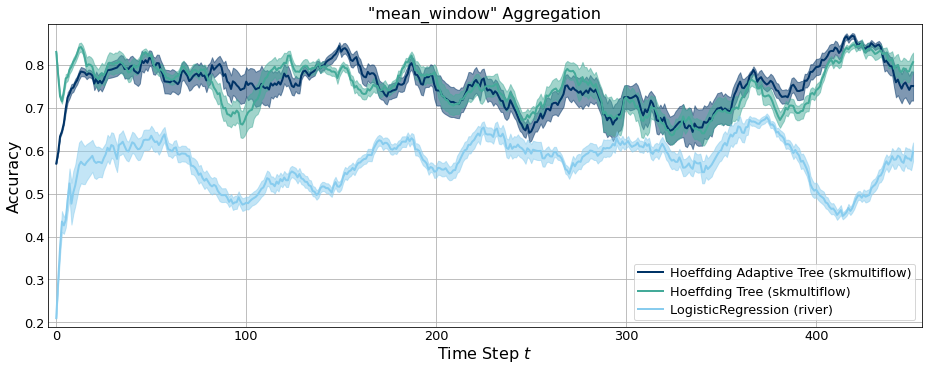

In [8]:
for mean, var in zip(['mean','mean_decay','mean_window'], ['var','var_decay','var_window']):
    ax = fvis.plot(measures=[evaluator.result['accuracy_score'][mean] for evaluator in pipeline.prediction_evaluators],
                   variance_measures=[evaluator.result['accuracy_score'][var] for evaluator in pipeline.prediction_evaluators],
                   legend_labels=['Hoeffding Adaptive Tree (skmultiflow)',
                                  'Hoeffding Tree (skmultiflow)', 
                                  'LogisticRegression (river)'],
                   y_label='Accuracy')
    
    # The returned matplotlib object can be altered and further customized.
    ax.set_title('"{}" Aggregation'.format(mean), fontsize=16)

    # plt.savefig('float/experiments/precision_decay.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
    plt.show()

Overall, the aggregated measures provide a less noisy result than the raw measures. The variance offers additional insight into the robustness and reliability of each classifier. In general, it depends on the application at hand, whether we want to report the raw measures or one of the aggregations. The decayed and sliding window aggregations seem a good compromise between smooth results and sufficient variability to capture the behaviour of the classifiers over time.

#### Additional Visualizations
Float also offers custom versions of the standard plot types scatter and bar.
For illustration, we plot a scatter chart of the noise-variability measures over time (note, however, that a different plot type would typically be more meaningful).

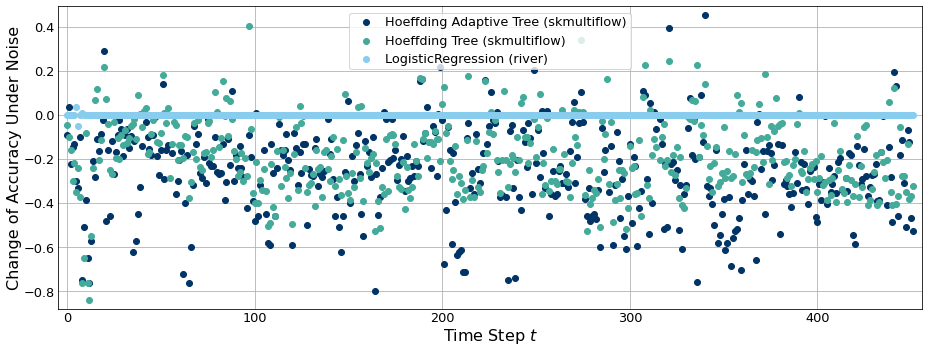

In [9]:
ax = fvis.scatter(measures=[evaluator.result['noise_variability']['measures'] for evaluator in pipeline.prediction_evaluators],
                  legend_labels=['Hoeffding Adaptive Tree (skmultiflow)',
                                 'Hoeffding Tree (skmultiflow)', 
                                 'LogisticRegression (river)'],
                  y_label='Change of Accuracy Under Noise')

#plt.savefig('float/experiments/noise_variability.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

Finally, we can use the spider chart to compare the classifiers w.r.t. different criteria in a very concise way.

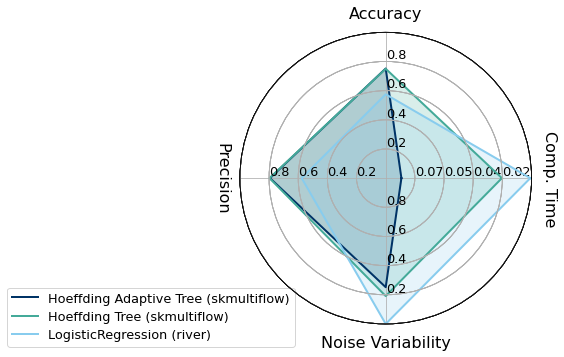

In [16]:
measures = []
measures.append([np.mean(evaluator.training_comp_times) for evaluator in pipeline.prediction_evaluators])
# We want to show the final mean measures (which correspond to the means over all time steps)
measures.append([evaluator.result['accuracy_score']['mean'][-1] for evaluator in pipeline.prediction_evaluators])
measures.append([evaluator.result['precision_score']['mean'][-1] for evaluator in pipeline.prediction_evaluators])
# Here, we want to show the absolute noise variability.
measures.append([np.abs(evaluator.result['noise_variability']['mean'][-1]) for evaluator in pipeline.prediction_evaluators])

ax = fvis.spider_chart(measures=measures,
                       measure_names=['Comp. Time', 'Accuracy', 'Precision', 'Noise Variability'],
                       legend_names=['Hoeffding Adaptive Tree (skmultiflow)',
                                     'Hoeffding Tree (skmultiflow)', 
                                     'LogisticRegression (river)'],
                       # We can specify the range of each measure (note that (0, 1) is also the default)
                       ranges=[(0, 0.09), (0, 1), (0, 1), (0, 1)],
                       # For the noise variability and computation time lower is better, thus we invert that measure.
                       invert=[True, False, False, True])

Based on the spider plot, we can easily make out advantages and disadvantages of each model. For example, while the LogisticRegression is more efficient and less sensitive to noise, it achieves considerably lower predictive performance. The Hoeffding Trees, on the other hand, obtained similar Accuracy and Precision. However, the regular HoeffdingTree has advantages in terms of the computation time and the noise variability. Based on this concise analysis, we may choose the regular HoeffdingTree for the application at hand.